# Training a Pizza Slice Angle Detector

In [4]:
## Define imports

## See 'dataloader.py' for custom dataloader class
from dataloader import create_data, PizzaDataset
## See 'model.py' for custom model class
from model import KeypointDetector
## See 'image_transforms.py' for custom image transforms
from image_transforms import *


## Some generic functions
from torchvision import transforms, utils
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import v2


## Load Data from SQL Database and Create Train-Test Split

In [5]:
dl = create_data('./data/pizza_database.db','pizza_table')
train, valid = dl.split_data(0.8, ['index','data_path','x1','y1','x2','y2','other'])

## Define Image Transform Pipeline

Uses a combination of custom functions and those from the Torch library.

The rescale function also rescales the label coordinates.

NB: Due to time constraints, I decided to just normalize the image dimensions of each image. In some instances the aspect ratios are altered, which potentially causes a change in the angle of the pizza slice. 

Inference can be run on the normalized data, and there is a function in the dataloader class ('transform_pred_to_normal') which rescales the keypoints back to the original height and width of the image before pre-processing.

In [8]:
transforms = v2.Compose([
    Rescale((224, 224)),
    Normalize(),
    v2.ToDtype(torch.float32),
])

## Transform Train Dataset

Create both transformed and untransformed datasets.

**Moving forward: x1,y1 is the tip and taken to be the origin point when calculating the angle relative to the vertical i.e. Y-axis**

The intention of both the data loader and the rest of this pipeline allows for **more training data to be added to the SQL database** so the model can be improved. 

Given more training data, batch size could be increased also. 

In [10]:
untransformed_train_dataset = PizzaDataset(train, './data/images')
transformed_train_dataset = PizzaDataset(train, './data/images', transforms)

print(f'Size of Training Dataset: {len(train)}')

train

Size of Training Dataset: 4


,index,data_path,x1,y1,x2,y2,other
0,676378,pizza0.jpg,65,905,108,875,None
1,603024,pizza1.jpg,99,243,99,224,None
2,893981,pizza3.jpg,1547,430,1466,420,None
3,162132,pizza4.jpg,270,409,325,399,None


## Visualize Examples

NB: Note Y-axis is flipped when interpreting printed angle. 

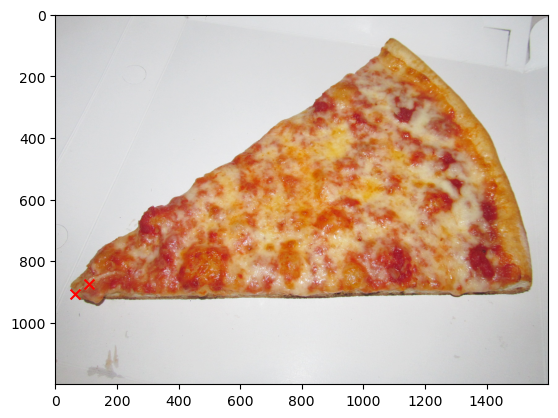

Angle of slice: 132.92996934695887


In [11]:
## Untransformed Image

eg0 = transformed_train_dataset.__getitem__(0)
eg0_u = untransformed_train_dataset.__getitem__(0)

dl.visualize_matrix_with_coordinates(eg0_u['image'], eg0_u['keypoints'], flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0['keypoints'])}")

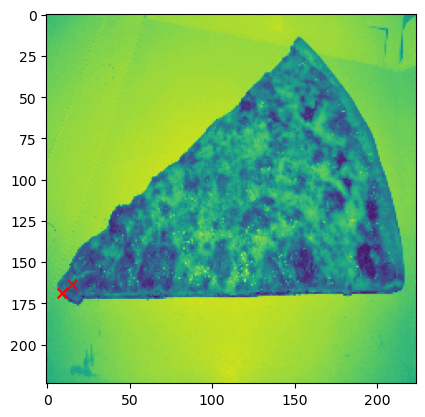

Angle of slice: 124.90249561592474


In [12]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg0['image'],eg0['keypoints'], flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(eg0_u['keypoints'])}")

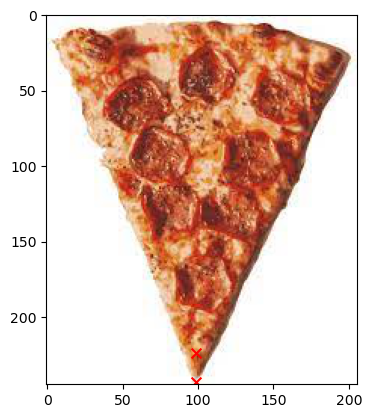

Angle of slice: 180.0


/home/sandippanesar/Desktop/pizza_angle_prediction/dataloader.py:179: RuntimeWarning: divide by zero encountered in double_scalars
  m = (points[3] - points[2]) / (points[1] - points[0])


In [13]:
## Untransformed Image

eg1 = transformed_train_dataset.__getitem__(1)
eg1_u = untransformed_train_dataset.__getitem__(1)

dl.visualize_matrix_with_coordinates(eg1_u['image'],eg1_u['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1['keypoints'])}")

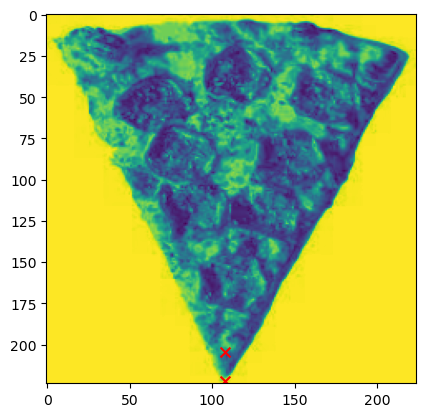

Angle of slice: 180.0


In [14]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg1['image'],eg1['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg1_u['keypoints'])}")

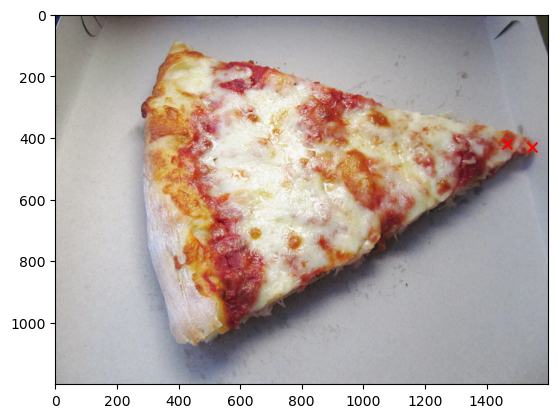

Angle of slice: 80.6524221903351


In [15]:
## Untransformed Image

eg2 = transformed_train_dataset.__getitem__(2)
eg2_u = untransformed_train_dataset.__getitem__(2)

dl.visualize_matrix_with_coordinates(eg2_u['image'],eg2_u['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

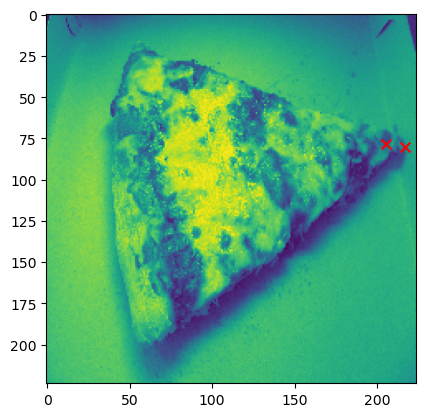

Angle of slice: 80.6524221903351


In [16]:
## Transformed Image

dl.visualize_matrix_with_coordinates(eg2['image'],eg2['keypoints'], flip_y=False)
print(f"Angle of slice: {dl.calculate_clockwise_angle(eg2['keypoints'])}")

## Create DataLoader Class For Datasets

In [17]:
train_loader = DataLoader(transformed_train_dataset, batch_size=1, shuffle=True)
untransformed_test_dataset = PizzaDataset(valid, './data/images')
transformed_test_dataset = PizzaDataset(valid, './data/images', transforms)
test_loader = DataLoader(transformed_test_dataset, batch_size=1, shuffle=True)

## Define Model Criteria For Training

L1Loss chosen specifically for keypoint detection task, over MSE or other loss functions. 

Has optional dropout layer.

Model 'KeypointDetector' contains: <br>
    - A convolutional layer <br>
    - A dropout layer <br>
    - A max pooling layer <br>
    - Another convolutional layer <br>
    - A dropout layer <br>
    - A fully connected layer <br>
    - Another fully connected layer which outputs an 1x4 array containing keypoint predictions [x1,x2,y1,y2]

Train model for 20 epochs. Might be overfit given size of training dataset. 

In [18]:
criterion = nn.L1Loss()
# device = 'cuda:0'
device = 'cpu'
num_epochs = 20

## Define model with drouput
model = KeypointDetector(use_dropout=True)
model.to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Define model without dropout
model2 = KeypointDetector(use_dropout=False)
model2.to(device)
model2 = model2.double()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

## Train Model w/o Dropout

Epoch [1/20], Loss: 96.6075
Epoch [2/20], Loss: 89.4517
Epoch [3/20], Loss: 77.4442
Epoch [4/20], Loss: 55.2641
Epoch [5/20], Loss: 66.6324
Epoch [6/20], Loss: 63.7445
Epoch [7/20], Loss: 58.3330
Epoch [8/20], Loss: 44.8522
Epoch [9/20], Loss: 65.6575
Epoch [10/20], Loss: 62.5134
Epoch [11/20], Loss: 60.9977
Epoch [12/20], Loss: 45.9365
Epoch [13/20], Loss: 64.2656
Epoch [14/20], Loss: 58.3298
Epoch [15/20], Loss: 60.1609
Epoch [16/20], Loss: 52.7741
Epoch [17/20], Loss: 53.6427
Epoch [18/20], Loss: 59.5858
Epoch [19/20], Loss: 45.5805
Epoch [20/20], Loss: 45.5334
Finished Training


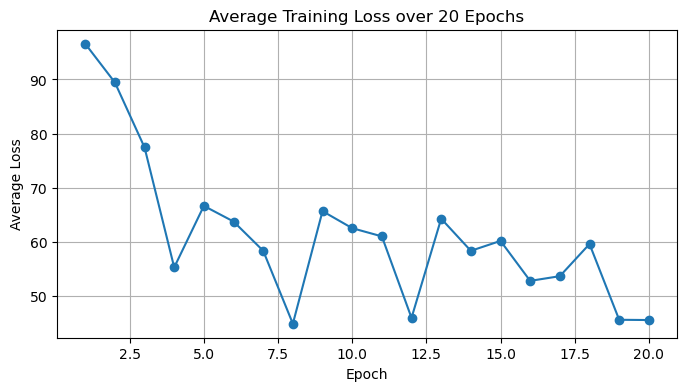

In [19]:
model.train_model(train_loader, criterion, optimizer, num_epochs, device)

## Train Model w/ Dropout

Epoch [1/20], Loss: 82.3577
Epoch [2/20], Loss: 88.4738
Epoch [3/20], Loss: 98.1546
Epoch [4/20], Loss: 71.0275
Epoch [5/20], Loss: 66.9632
Epoch [6/20], Loss: 57.9918
Epoch [7/20], Loss: 85.6712
Epoch [8/20], Loss: 79.7051
Epoch [9/20], Loss: 68.0050
Epoch [10/20], Loss: 70.7276
Epoch [11/20], Loss: 63.1107
Epoch [12/20], Loss: 55.3681
Epoch [13/20], Loss: 54.8978
Epoch [14/20], Loss: 56.7542
Epoch [15/20], Loss: 54.8794
Epoch [16/20], Loss: 57.0465
Epoch [17/20], Loss: 51.5654
Epoch [18/20], Loss: 50.2793
Epoch [19/20], Loss: 55.0557
Epoch [20/20], Loss: 51.1545
Finished Training


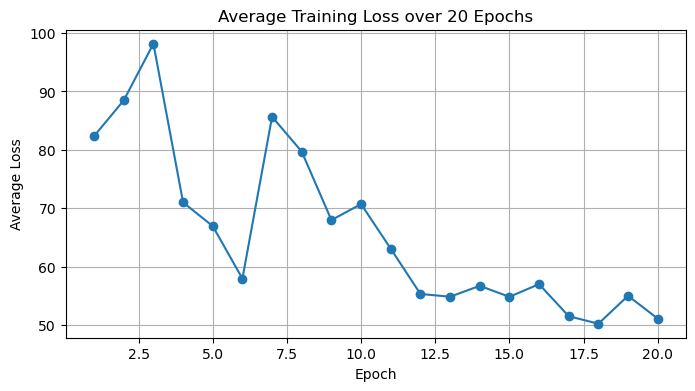

In [20]:
model2.train_model(train_loader, criterion, optimizer2, num_epochs, device)

## Run Evaluation on Validation Set

In [21]:
e1 = model.evaluate_model(model, test_loader, criterion, device)
e2 = model.evaluate_model(model2, test_loader, criterion, device)

print(f'Performance of first model on test dataset (average loss): {e1}')
print('-'*50)
print(f'Performance of second model on test dataset (average loss): {e2}')

Performance of first model on test dataset (average loss): 102.19229096475998
--------------------------------------------------
Performance of second model on test dataset (average loss): 75.57393738579673


## Visualize the Predictions on Untransformed Validation Data

In [22]:
test_0 = transformed_test_dataset.__getitem__(0)
m1_preds = model.predict(model, test_0['image'])
m2_preds = model.predict(model2, test_0['image'])

m1_preds_rescaled = dl.transform_pred_to_normal(m1_preds, (224,224), untransformed_test_dataset.__getitem__(0)['image'])
m2_preds_rescaled = dl.transform_pred_to_normal(m2_preds, (224,224), untransformed_test_dataset.__getitem__(0)['image'])

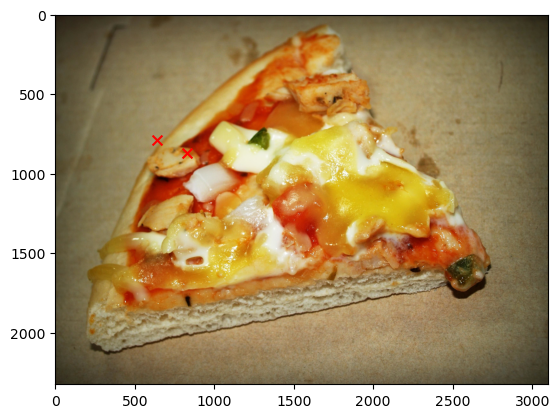

Angle of slice: 67.53800581619502


In [23]:
## Model 1

dl.visualize_matrix_with_coordinates(untransformed_test_dataset.__getitem__(0)['image'], m1_preds_rescaled, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m1_preds_rescaled)}")

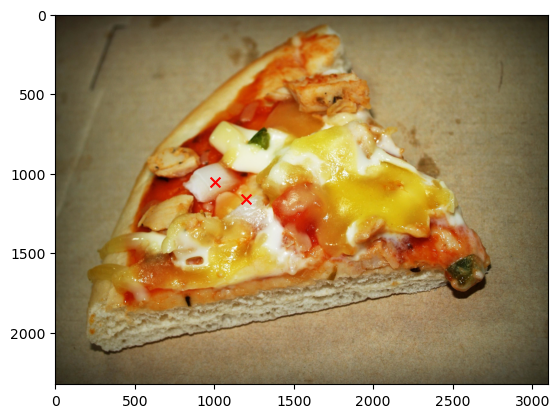

Angle of slice: 61.512314946666244


In [24]:
## Model 2

dl.visualize_matrix_with_coordinates(untransformed_test_dataset.__getitem__(0)['image'], m2_preds_rescaled, flip_y=False)

print(f"Angle of slice: {dl.calculate_clockwise_angle(m2_preds_rescaled)}")

## Conclusions

- Both models perform generally the same.
- On the test dataset the predicted angle is somewhat correct, despite the keypoints not being correct. 


## Improvements

- Larger training set. 
- Potentially exploring different model architectures, pretrained models e.g. ResNet-50 etc. 